# Result_Fig3_2 : Difficulty with Tag Availability

In [1]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')

sys.path.insert(1, p)
sys.path.insert(1, pp)



In [2]:
from utils.statistics import *
from utils.settings import *

from constants import CONSTANTS

import numpy as np
import pandas as pd
import json
import itertools
import seaborn as sns
import datetime
import pickle
import networkx as nx

import matplotlib.pyplot as plt
colors = plt.get_cmap('tab20').colors 



In [3]:
path = CONSTANTS.s_diff_da_result_path
file_list = os.listdir(f'{path}/raw')

diff_dict = {'0':'Basic', '1':'Intermediate', '2':'Advanced'}

In [4]:
with open(f'{path}/raw/{file_list[0]}', 'rb') as f:
    tot_t_list = pickle.load(f)

In [5]:
tot_t_list.loc[:, 'tags_list'] = tot_t_list['tags'].apply(lambda x : x.replace('><', ' ').replace('<', '').replace('>', '').split(' '))
tot_t_list['tags_list'] = tot_t_list['tags_list'].apply(lambda x : list(itertools.product((x), repeat=2)))
tot_t_list['tags_list'] = tot_t_list['tags_list'].apply(lambda x :sorted(x))

In [6]:
# diff_t_list = 
tot_t_list = tot_t_list.explode('tags_list')

In [7]:
tot_t_list['tags_for_n'] = tot_t_list['tags_list'].apply(lambda x : '' if x[0]==x[1] else x)

In [8]:
tot_t_list = tot_t_list[tot_t_list['tags_for_n'] != ''].reset_index(drop=True)

In [9]:
tot_t_list.head()

,id,creationdate,difficulty,tags,tags_list,tags_for_n
0,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(math, python)","(math, python)"
1,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(math, square-root)","(math, square-root)"
2,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(python, math)","(python, math)"
3,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(python, square-root)","(python, square-root)"
4,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(square-root, math)","(square-root, math)"


In [10]:
tot_t_list['rel_week'] = np.floor((pd.to_datetime(tot_t_list['creationdate'], format='mixed')- datetime.datetime(2022,11,30)).dt.days/7)

In [11]:
tot_t_list = tot_t_list[(tot_t_list['rel_week']>-53) & (tot_t_list['rel_week']<52)]

In [12]:
tot_t_list['gpt_yn'] = np.where(tot_t_list['rel_week']<0, 0, 1)

In [13]:
def make_network(tag_for_n_list) : 
    G = nx.Graph()
    G.add_edges_from(tag_for_n_list)
    return G

In [14]:
g_yn_dict = dict()
for diff in diff_dict.keys():
    g_yn_dict[diff] = dict()
    tmp = tot_t_list[tot_t_list['difficulty'] == diff]
    for yn in tmp['gpt_yn'].unique():
        tmp2 = tmp[tmp['gpt_yn'] == yn]
        g_yn_dict[diff][yn] = make_network([x for x in tmp2['tags_for_n']])
        

In [15]:
def calc_entropy_contributions(G):
    degrees = np.array([degree for _, degree in G.degree()])
    degree_sum = degrees.sum()
    p = degrees / degree_sum
    entropy_contributions = - p * np.log(p)
    node_names = [node for node, _ in G.degree()]
    return dict(zip(node_names, entropy_contributions))

In [16]:
b_dict = dict()
a_dict = dict()
d_dict = dict()
for diff in diff_dict.keys():
    b_dict[diff] = calc_entropy_contributions(g_yn_dict[diff][0])
    a_dict[diff] = calc_entropy_contributions(g_yn_dict[diff][1])

    d_dict[diff] = {node: a_dict[diff].get(node, 0) - b_dict[diff].get(node, 0)
        for node in set(list(b_dict[diff].keys()) + list(a_dict[diff].keys()))}


In [17]:
value_dict = dict()

for idx, diff in enumerate(diff_dict.keys()):
    all_nodes           = len(list(set(b_dict[diff].keys()).union(a_dict[diff].keys())))
    new_nodes           = len(set(a_dict[diff].keys()) - set(b_dict[diff].keys()))
    disapperaed_nodes   = len(set(b_dict[diff].keys()) - set(a_dict[diff].keys()))
    
    new_ratio           = new_nodes/all_nodes
    disapperaed_ratio   = disapperaed_nodes/all_nodes
    remain_ratio        = 1- new_ratio - disapperaed_ratio

    value_dict[diff] = [new_ratio,disapperaed_ratio, remain_ratio]




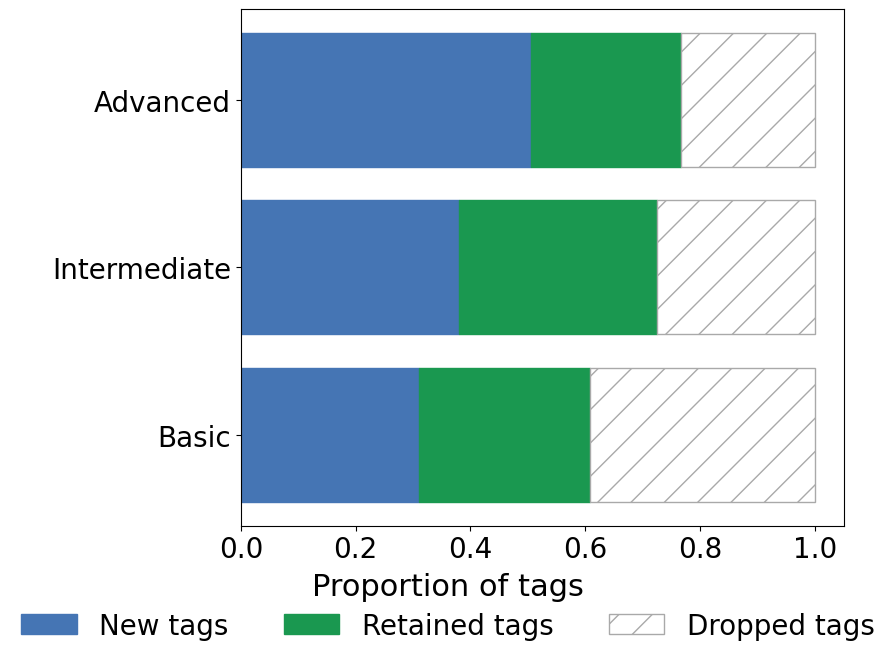

In [18]:
categories = list(diff_dict.keys())  
new = [value_dict[x][0] for x in diff_dict.keys()]
gone = [value_dict[x][1] for x in diff_dict.keys()]
left = [value_dict[x][2] for x in diff_dict.keys()]


fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)


ax.barh(categories, new, label='New tags', color="#4575b4", edgecolor="#4575b4")
ax.barh(categories, left, left=new, label='Retained tags', color="#1a9850", edgecolor="#1a9850")


left_sum = [v1 + v2 for v1, v2 in zip(new, left)]
ax.barh(categories, gone, left=left_sum, label='Dropped tags', color='white', edgecolor='#A9A9A9', hatch='/')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([f'{x}' for x in list(diff_dict.values())], ha='right')  # 원하는 텍스트로 바꾸기


ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

fig.supxlabel('Proportion of tags', fontsize=22)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=20,
    frameon=False
)


plt.savefig(f"./fig/C_Result_Fig3_2.png", dpi=300, bbox_inches='tight')

plt.show()
